In [1]:

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X.to_numpy()
y = y.to_numpy()
random_idx = np.random.randint(X.shape[0])
some_digit = X[random_idx]

In [2]:
X_train, X_test, y_train, y_test = X[:10000], X[10000:], y[:10000], y[10000:]

## 연습문제1. 그리드 탐색

In [3]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.940 total time=   3.2s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.943 total time=   1.0s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.948 total time=   0.9s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.933 total time=   0.8s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.934 total time=   0.9s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.942 total time=   1.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.947 total time=   1.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.951 total time=   1.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.937 total time=   0.8s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.936 total time=   0.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.936 total time=   0.8s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [4]:
print(grid_search.best_params_, grid_search.best_score_)

{'n_neighbors': 4, 'weights': 'distance'} 0.9441999999999998


In [5]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9503

## 연습문제2. sklearn augmentation

In [6]:
from scipy.ndimage.interpolation import shift

def prac_2(image, down, right):
    image = image.reshape(28, 28)
    return_image = shift(image, [down, right]) # default 이미지 이동후 input 값이 없는 빈공간은 0으로 채움
    return return_image

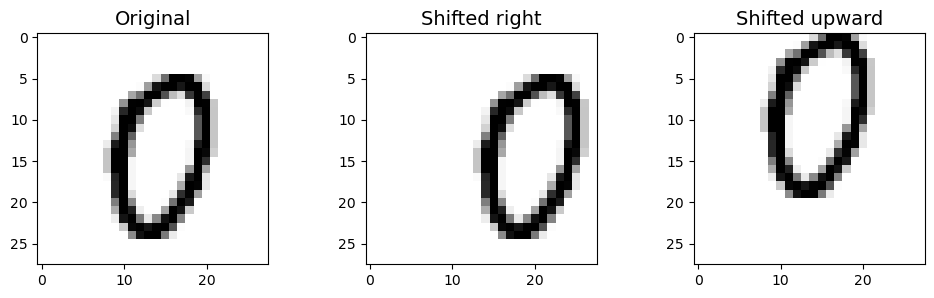

In [8]:
image = X_train[1000]
shifted_image_1 = prac_2(image, 0, 5)
shifted_image_2 = prac_2(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="binary")
plt.subplot(132)
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_1, interpolation="nearest", cmap="binary")
plt.subplot(133)
plt.title("Shifted upward", fontsize=14)
plt.imshow(shifted_image_2, interpolation="nearest", cmap="binary")
plt.show()

In [10]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(prac_2(image, dy, dx).reshape(-1))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

shuffle_idx = np.random.choice(len(X_train_augmented), len(X_train_augmented), replace=False)
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9601666666666666

## 연습문제3. Titanic

In [11]:
import os
import urllib.request
import pandas as pd

titanic_data_path = os.path.join(os.getcwd(), "datasets", "titanic")
down_url = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=down_url, path=titanic_data_path):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

def load_titanic_data(filename, titanic_path=titanic_data_path):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [12]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [16]:
# 수치형 특성 파이프라인 구성

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), # 빈칸은 중간값으로 채우기
        ("scaler", StandardScaler())
    ])

In [17]:
# 범주형 특성 파이프라인 구성
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")), # 빈칸은 가장 빈번히 등장하는 카테고리로 채우기
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [18]:
# 파이프라인 연결
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [25]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
enc = OneHotEncoder(handle_unknown='ignore')
y_train = train_data["Survived"]

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [28]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8216479400749064

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

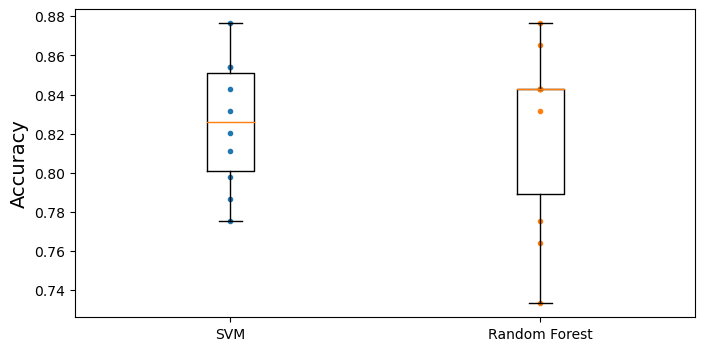

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [32]:

train_data["AgeBucket_15"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket_15", "Survived"]].groupby(['AgeBucket_15']).mean()

,Survived
AgeBucket_15,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [33]:

train_data["AgeBucket_10"] = train_data["Age"] // 10 * 10
train_data[["AgeBucket_10", "Survived"]].groupby(['AgeBucket_10']).mean()

,Survived
AgeBucket_10,
0.0,0.612903
10.0,0.401961
20.0,0.350000
30.0,0.437126
40.0,0.382022
50.0,0.416667
60.0,0.315789
70.0,0.000000
80.0,1.000000


In [34]:

train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 연습문제4. 스팸분류기